In [1]:
%cd C:\Users\yukir\Documents\Monicas_workspace\py_storage

C:\Users\yukir\Documents\Monicas_workspace\py_storage


In [2]:
from basic_preprocessing import *

In [3]:
from deeplearning_check import *

In [4]:
/pwd

'C:\\Users\\yukir\\Documents\\Monicas_workspace\\py_storage'

In [5]:
%cd C:\Users\yukir\Documents\Monicas_workspace\Sign detection\classification

C:\Users\yukir\Documents\Monicas_workspace\Sign detection\classification


In [6]:
IMG_SIZE = 100
NUM_EPOCHS = 10
NUM_CLASSES = 2
TRAIN_BATCH_SIZE = 77
TEST_BATCH_SIZE = 1 
opt =  tf.optimizers.Adam()

In [7]:
def create_model():
  #resnet_weights_path = '/content/drive/MyDrive/Caba2012_colab/Fire_dt/models/resnet.h5'
  #resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

  #weigths = weights=resnet_weights_path ->none
  resnet = ResNet50(include_top=False, pooling='avg', weights = None)
  #resnet.summary()
  my_new_model = Sequential()
  my_new_model.add(resnet)
  my_new_model.layers[0].trainable = True
  my_new_model.add(Dense(NUM_CLASSES, activation='softmax')) #dense 3, NUM_CLASSES = 3

  # Say no to train first layer (ResNet) model. It is already trained
    
  opt =  tf.optimizers.Adam()
   #opt바꾼거 확인해
  my_new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return my_new_model

In [8]:
/pwd

'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\classification'

In [9]:
def train_model( model ):
    data_generator = ImageDataGenerator(rescale=1./255)
    
    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )

    train_generator = data_generator_with_aug.flow_from_directory(
        'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0723\\[0723] dataset\\train', 
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=TEST_BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')

    validation_generator = data_generator_with_aug.flow_from_directory(
        'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0723\\[0723] dataset\\val', 
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=TEST_BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')



    test_generator = data_generator.flow_from_directory(
        'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0723\\[0723] dataset\\test', 
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=TEST_BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')

    H = model.fit(
                train_generator,
                steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
                epochs=NUM_EPOCHS,
                validation_data=validation_generator,
                validation_steps = 1 
                #,
                #class_weight=dict_weights
                    )
    
    plot_history( H, NUM_EPOCHS )
    
    return H, model, train_generator, validation_generator ,test_generator
    

In [10]:
def get_label_dict(train_generator ):
# Get label to class_id mapping
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict   

In [11]:
def get_labels( test_generator ):
    test_generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)

In [12]:
def get_pred_labels( test_generator):
    test_generator.reset()
    pred_vec=model.predict_generator(test_generator,
                                     steps=test_generator.n, #test_generator.batch_size
                                     verbose=1)
    return np.argmax( pred_vec, axis = 1), np.max(pred_vec, axis = 1)

In [13]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

    
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_accuracy")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_accuracy")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


    plt.show()

In [14]:
def draw_prediction( frame, class_string ):
    x_start = frame.shape[1]- 600 # 위치
    cv2.putText(frame, class_string, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [15]:
def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

#### Training

In [16]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


Found 2968 images belonging to 2 classes.
Found 370 images belonging to 2 classes.
Found 374 images belonging to 2 classes.
Epoch 1/10
39/38 [==============================] - 2s 47ms/step - loss: 1.6925 - accuracy: 0.4103 - val_loss: 7.4882 - val_accuracy: 0.0000e+00
Epoch 2/10
39/38 [==============================] - 1s 32ms/step - loss: 2.4983 - accuracy: 0.5385 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
39/38 [==============================] - 1s 30ms/step - loss: 1.9547 - accuracy: 0.5641 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
39/38 [==============================] - 1s 29ms/step - loss: 3.4282 - accuracy: 0.4615 - val_loss: 59.2204 - val_accuracy: 0.0000e+00
Epoch 5/10
39/38 [==============================] - 1s 30ms/step - loss: 1.6816 - accuracy: 0.4872 - val_loss: 0.6261 - val_accuracy: 1.0000
Epoch 6/10
39/38 [==============================] - 1s 30ms/step - loss: 1.2971 - accuracy: 0.4615 - val_loss: 0.6263 - val_accuracy: 1.0000
Epoch 7/10
39

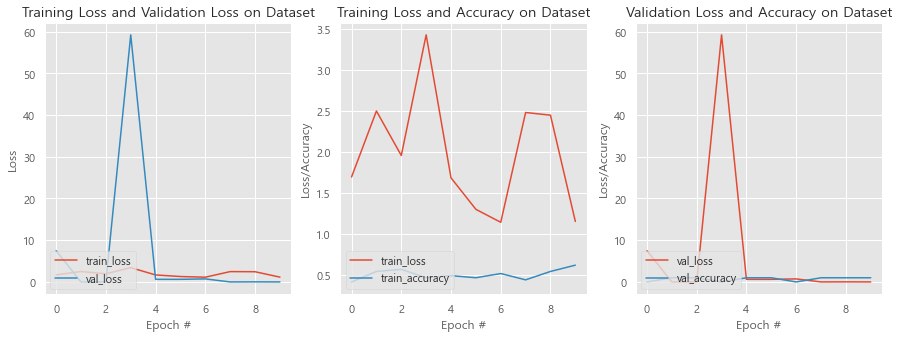

In [17]:
H, trained_model,train_generator,validation_generator, test_generator = train_model(model)
label_dict= get_label_dict(train_generator)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.save('/content/drive/MyDrive/Caba2012_colab/Fire_dt/models/resnet.h5')

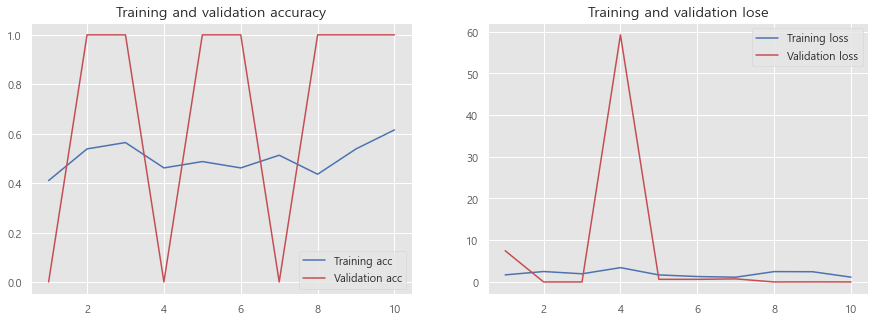

In [18]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(1, len(acc) +1)
    
    

fig = plt.figure()
fig.set_size_inches(15, 5)

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label ='Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1, 2, 2) 
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and validation lose')
plt.legend()

plt.show()

In [19]:
model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy',\
                      tf.keras.metrics.Precision(name='precision')\
                          ,tf.keras.metrics.Recall(name='recall')\
                          ,tf.keras.metrics.FalsePositives(name='false_positives')\
                          ,tf.keras.metrics.FalseNegatives(name='false_negatives'),\
                      tf.keras.metrics.TruePositives(name ='true_positives'),\
                     tf.keras.metrics.TrueNegatives(name ='true_negatives')])
# #                      tf.keras.metrics.SensitivityAtSpecificity(specificity, num_thresholds=200, name='SensitivityAtSpecificity', dtype=None),\
#                      tf.keras.metrics.SpecificityAtSensitivity(name='SpecificityAtSensitivity')])

In [20]:
# 반환되는 "이력" 객체는 훈련 중 손실 값과 메트릭 값에 대한 레코드를 유지합니다.
H.history

{'loss': [1.6925183534622192,
  2.4983081817626953,
  1.954728126525879,
  3.4282453060150146,
  1.6815502643585205,
  1.2971231937408447,
  1.138870120048523,
  2.479973316192627,
  2.4470345973968506,
  1.1488633155822754],
 'accuracy': [0.41025641560554504,
  0.5384615659713745,
  0.5641025900840759,
  0.4615384638309479,
  0.4871794879436493,
  0.4615384638309479,
  0.5128205418586731,
  0.43589743971824646,
  0.5384615659713745,
  0.6153846383094788],
 'val_loss': [7.488224029541016,
  0.0,
  0.0,
  59.22041320800781,
  0.626085638999939,
  0.6262707114219666,
  0.7300494313240051,
  0.0011848341673612595,
  0.021084455773234367,
  0.0021822466515004635],
 'val_accuracy': [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]}

In [21]:
result = model.evaluate(test_generator)
type(result)

374/374 [==============================] - 4s 11ms/step - loss: 3.0416 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000 - false_positives: 187.0000 - false_negatives: 187.0000 - true_positives: 187.0000 - true_negatives: 187.0000


list

In [22]:
def evaluating_each(result):
    from keras import backend as K
    
    loss = result[0]
    accuracy = result[1]
    precision = result[2]
    recall = result[3]
    f_p = int(result[4])
    f_n = int(result[5])
    t_p = int(result[6])
    t_n = int(result[7])
    
    f1_score = (2 * recall * precision) / (recall + precision + K.epsilon())
    sensitivity = t_p / (t_p + f_n)
    specificity = t_n/ (t_n + f_p)
    
    print("""loss:{:.3f}, \naccuracy:{:.3f}, \nprecision:{:.3f}, \nrecall:{:.3f}, \nFalse_positive:{}, \nFalse_negative, :{}, \nTrue_positive:{}, \nTrue_negative:{}, \nSensitivity:{:.3f}, \nSpecificity:{:.3f}, \nF1_score:{:.3f}""".format(loss, accuracy, precision, recall, f_p, f_n, t_p, t_n, sensitivity, specificity, f1_score))
    return loss, accuracy, precision, recall, f_p, f_n, t_p, t_n, sensitivity, specificity, f1_score

In [23]:
evaluating_each(result)

loss:3.042, 
accuracy:0.500, 
precision:0.500, 
recall:0.500, 
False_positive:187, 
False_negative, :187, 
True_positive:187, 
True_negative:187, 
Sensitivity:0.500, 
Specificity:0.500, 
F1_score:0.500


(3.041621446609497,
 0.5,
 0.5,
 0.5,
 187,
 187,
 187,
 187,
 0.5,
 0.5,
 0.49999995000000497)

In [24]:
get_label_dict(train_generator)

{0: 'fragile', 1: 'up'}

In [25]:
def get_labels( generator ):
    generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)

In [26]:
get_labels(train_generator)

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [27]:
get_pred_labels(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.
374/374 [==============================] - 3s 7ms/step


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Real pic test

In [28]:
get_label_dict(train_generator)

{0: 'fragile', 1: 'up'}

In [29]:
results={
   0:'fragile',
   1:'up',
   2:'bird',
   3:'cat',
   4:'deer',
   5:'dog',
   6:'frog',
   7:'horse',
   8:'ship',
   9:'truck'
}
from PIL import Image
import numpy as np
im=Image.open("C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0724 test\\preprocessing\\ge\\up\\(1)blankstock180501065.jpg")
# the input image is required to be in the shape of dataset, i.e (32,32,3)
 
im=im.resize((80,80))
im=np.expand_dims(im,axis=0)
im=np.array(im)
pred=model.predict_classes([im])[0]
print(pred,results[pred])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
1 up


In [30]:
results={
   0:'fragile',
   1:'up',
   2:'bird',
   3:'cat',
   4:'deer',
   5:'dog',
   6:'frog',
   7:'horse',
   8:'ship',
   9:'truck'
}
columns =['file_name', 'label', 'class']
answer = []
for i in file_list:
    im=Image.open(i)
    # the input image is required to be in the shape of dataset, i.e (32,32,3)
    i= i.split('\\')[-1]
    im=im.resize((100,100))
    im=np.expand_dims(im,axis=0)
    im=np.array(im)
    pred=model.predict_classes([im])[0]
    answer.append([i, pred, results[pred]])
    answer_df = pd.DataFrame(answer, columns = columns )
answer_df.head()

TypeError: 'function' object is not iterable

In [ ]:
answer_df['class'].value_counts()

### save

In [ ]:
# model.save('[0725]data_aug_sametest.h5')

# # Save model with json format 
# model_json = model.to_json() 
# with open("[0725]data_aug_sametest.json", "w") as json_file:
#     json_file.write(model_json)
    
# # Save weight with h5 format
# model.save_weights("[0725]data_aug_sametest_weight.h5")
# print("Saved model to disk")